In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
DIRECTORY = r"C:\Users\ANURAG DHAWAN\Desktop\PROJECT\Datasets\dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [4]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    for img in os.listdir(path):
            img_path = os.path.join(path, img)
            image = load_img(img_path, target_size=(224, 224))
            image = img_to_array(image)
            image = preprocess_input(image)

            data.append(image)
            labels.append(category)

c:\users\anurag dhawan\appdata\local\programs\python\python38\lib\site-packages\PIL\Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [6]:
print(data[:5])
print(labels[:5])

[array([[[-0.45098037, -0.49019605, -0.44313723],
        [-0.45098037, -0.49019605, -0.44313723],
        [-0.45098037, -0.49019605, -0.44313723],
        ...,
        [-0.41176468, -0.62352943, -0.75686276],
        [-0.41176468, -0.62352943, -0.75686276],
        [-0.41176468, -0.62352943, -0.75686276]],

       [[-0.45098037, -0.49019605, -0.44313723],
        [-0.45098037, -0.49019605, -0.44313723],
        [-0.45098037, -0.49019605, -0.44313723],
        ...,
        [-0.41176468, -0.62352943, -0.75686276],
        [-0.41176468, -0.62352943, -0.75686276],
        [-0.41176468, -0.62352943, -0.75686276]],

       [[-0.3960784 , -0.45098037, -0.3960784 ],
        [-0.3960784 , -0.45098037, -0.3960784 ],
        [-0.3960784 , -0.45098037, -0.3960784 ],
        ...,
        [-0.45098037, -0.62352943, -0.8039216 ],
        [-0.45098037, -0.62352943, -0.8039216 ],
        [-0.45098037, -0.62352943, -0.8039216 ]],

       ...,

       [[-0.46666664, -0.67058825, -0.8039216 ],
        [-

In [7]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
labels[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.1, stratify=labels, random_state=42)

In [9]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

9412608/9406464 [==============================] - 8s 1us/step


In [10]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [14]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])


In [15]:
H = model.fit(
        trainX, trainY, batch_size=BS,
        steps_per_epoch=len(trainX) // BS,
        validation_data=(testX, testY),
        validation_steps=len(testX) // BS,
        epochs=EPOCHS)

Epoch 1/20
107/107 [==============================] - 80s 750ms/step - loss: 0.3111 - accuracy: 0.8744 - val_loss: 0.0746 - val_accuracy: 0.9818
Epoch 2/20
107/107 [==============================] - 76s 709ms/step - loss: 0.0904 - accuracy: 0.9710 - val_loss: 0.0482 - val_accuracy: 0.9870
Epoch 3/20
107/107 [==============================] - 78s 727ms/step - loss: 0.0602 - accuracy: 0.9795 - val_loss: 0.0413 - val_accuracy: 0.9896
Epoch 4/20
107/107 [==============================] - 81s 752ms/step - loss: 0.0437 - accuracy: 0.9871 - val_loss: 0.0369 - val_accuracy: 0.9896
Epoch 5/20
107/107 [==============================] - 83s 780ms/step - loss: 0.0343 - accuracy: 0.9889 - val_loss: 0.0346 - val_accuracy: 0.9896
Epoch 6/20
107/107 [==============================] - 84s 790ms/step - loss: 0.0286 - accuracy: 0.9912 - val_loss: 0.0327 - val_accuracy: 0.9922
Epoch 7/20
107/107 [==============================] - 81s 753ms/step - loss: 0.0240 - accuracy: 0.9933 - val_loss: 0.0331 - val_ac

In [16]:
predIdxs = model.predict(testX, batch_size=BS)

In [17]:
predIdxs = np.argmax(predIdxs, axis=1)

In [18]:
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       192
without_mask       0.99      0.98      0.99       192

    accuracy                           0.99       384
   macro avg       0.99      0.99      0.99       384
weighted avg       0.99      0.99      0.99       384



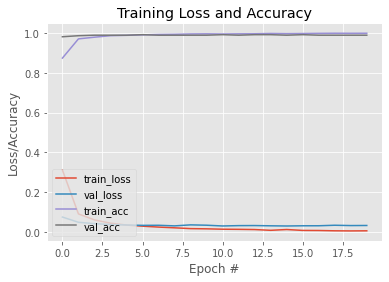

In [19]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")

In [20]:
model.save("mask_detector.model", save_format="h5")